In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import os

## Boxplot Generation & Statistical Analysis: GNN vs. Oi2

### Generate Boxplot:

#### Read GNN train and test prc value CSVs

In [30]:
train_prcs = pd.read_csv('../processed-data-files/train_prc_values.csv', sep='\t')
train_prcs.drop(columns=['Unnamed: 0', 'precision', 'recall', 'thresholds'], inplace=True)
len(train_prcs)

656

In [32]:
test_prcs = pd.read_csv('../processed-data-files/test_prc_values.csv', sep='\t')
test_prcs.drop(columns=['Unnamed: 0', 'precision', 'recall', 'thresholds'], inplace=True)
len(test_prcs)

164

In [33]:
train_prcs['pathway'] = (
    train_prcs['file_name']
    .str.extract(r'^(.*)_train_\d+\.txt$')[0]
    .str.replace(r'\W+', '_', regex=True)
    .str.strip('_')
)

test_prcs['pathway'] = (
    test_prcs['file_name']
    .str.extract(r'^(.*)_train_\d+\.txt$')[0]
    .str.replace(r'\W+', '_', regex=True)
    .str.strip('_')
)

#### Read Oi2 prc value CSVs

In [34]:
oi2_prc_df = pd.read_csv('../processed-data-files/oi2_apscore_nodefile.csv', sep='\t')
oi2_prc_df.rename(columns={'Sample':'sample', 'AveragePrecision':'average_precision'}, inplace=True)
oi2_prc_df['pathway'] = oi2_prc_df['sample'].str[:-4]
oi2_prc_df.head()

,sample,average_precision,dataset_label,node_file,pathway
0,alanine__aspartate_a.txt,0.016665,alanine__a_1510-ml,alanine__aspartate_a_train_1510_nodes.txt,alanine__aspartate_a
1,alanine__aspartate_a.txt,0.023841,alanine__a_2535-ml,alanine__aspartate_a_train_2535_nodes.txt,alanine__aspartate_a
2,alanine__aspartate_a.txt,0.020378,alanine__a_3273-ml,alanine__aspartate_a_train_3273_nodes.txt,alanine__aspartate_a
3,alanine__aspartate_a.txt,0.027565,alanine__a_3711-ml,alanine__aspartate_a_train_3711_nodes.txt,alanine__aspartate_a
4,alanine__aspartate_a.txt,0.005766,alanine__a_3781-ml,alanine__aspartate_a_train_3781_nodes.txt,alanine__aspartate_a


#### Build box plots

In [35]:
# tag each source
d_gnn = train_prcs.assign(source='gnn')
d_oi2 = oi2_prc_df.assign(source='oi2')

In [37]:
# stack them into one “long” DataFrame
long = pd.concat([d_gnn, d_oi2], ignore_index=True)

print(len(set(long['pathway'])))
# long[long['pathway']=='alanine__aspartate_a']

# x-axis order - take all pathways in sorted order:
order = sorted(long['pathway'].unique())


82


In [26]:
long

,file_name,average_precision,pathway,source,sample,dataset_label,node_file
0,alanine__aspartate_a_train_2535.txt,0.221453,NaN,gnn,NaN,NaN,NaN
1,alanine__aspartate_a_train_3273.txt,0.087795,NaN,gnn,NaN,NaN,NaN
2,alanine__aspartate_a_train_3711.txt,0.256911,NaN,gnn,NaN,NaN,NaN
3,alanine__aspartate_a_train_3781.txt,0.105447,NaN,gnn,NaN,NaN,NaN
4,alanine__aspartate_a_train_6130.txt,0.139379,NaN,gnn,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1245,NaN,0.060233,terpenoid_backbone_b,oi2,terpenoid_backbone_b.txt,terpenoid_6621-ml,terpenoid_backbone_b_train_6621_nodes.txt
1246,NaN,0.006909,terpenoid_backbone_b,oi2,terpenoid_backbone_b.txt,terpenoid_8657-ml,terpenoid_backbone_b_train_8657_nodes.txt
1247,NaN,0.000248,terpenoid_backbone_b,oi2,terpenoid_backbone_b.txt,terpenoid_8661-ml,terpenoid_backbone_b_train_8661_nodes.txt
1248,NaN,0.033571,terpenoid_backbone_b,oi2,terpenoid_backbone_b.txt,terpenoid_9404-ml,terpenoid_backbone_b_train_9404_nodes.txt


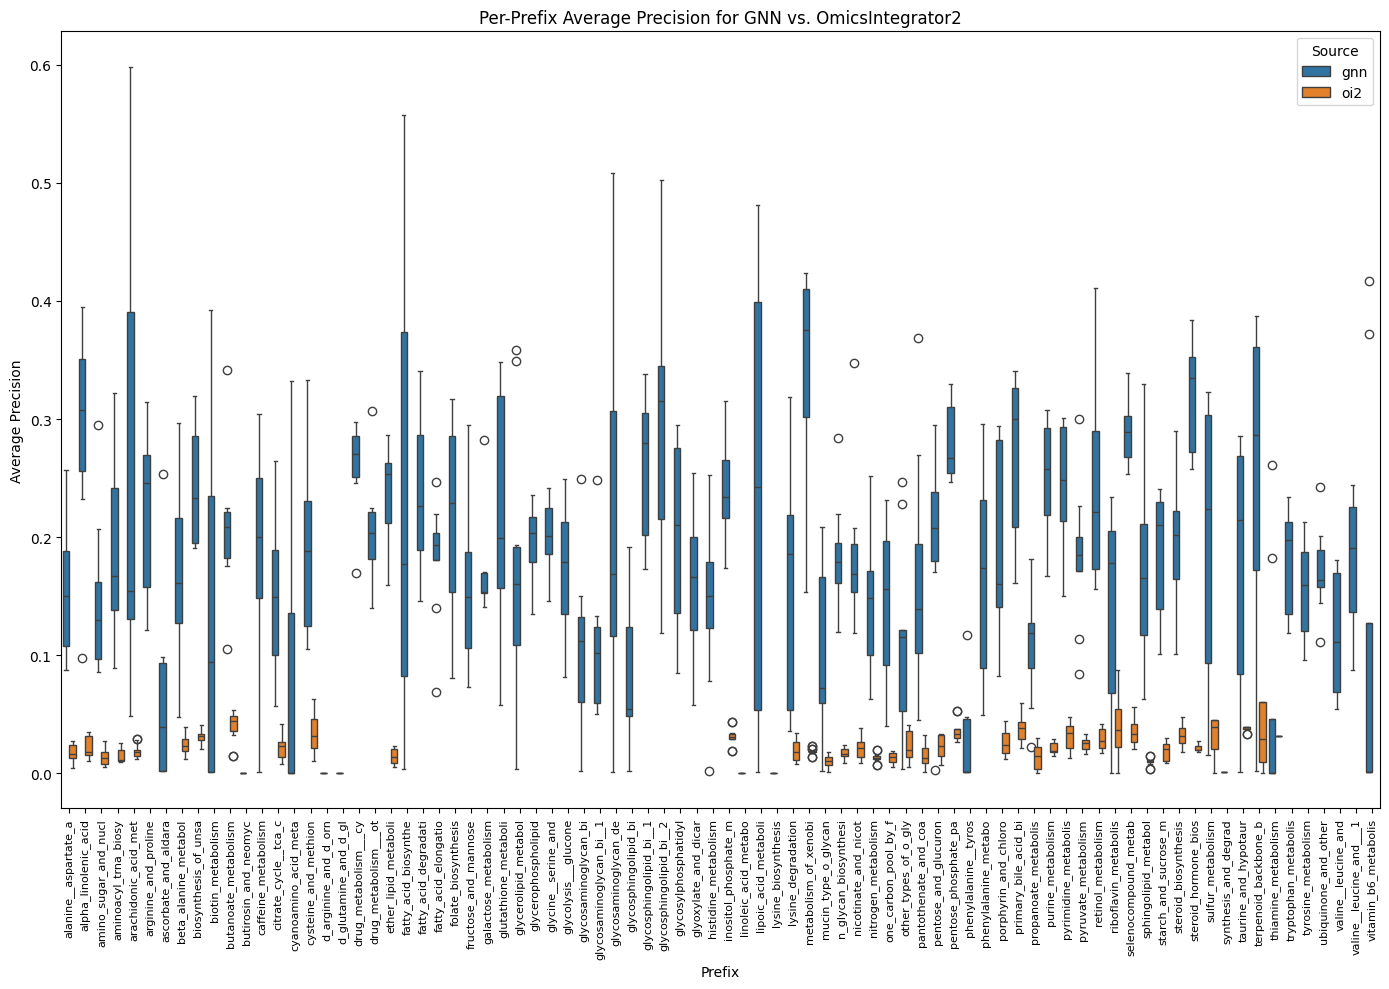

In [38]:
# draw the boxplot
plt.figure(figsize=(14,10))
sns.boxplot(
    data=long,
    x='pathway',
    y='average_precision',
    hue='source',
    order=order,
    palette={'oi2':'#FF7F0E','gnn':'#1F77B4'}
)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel("Prefix")
plt.ylabel("Average Precision")
plt.title("Per-Prefix Average Precision for GNN vs. OmicsIntegrator2")
plt.legend(title="Source")
plt.tight_layout()
plt.show()

### Statistical Analysis

In [39]:
gnn_df = train_prcs[['file_name','pathway','average_precision']].rename(
    columns={'average_precision':'ap_gnn'}
)

gnn_df['file_name'] = gnn_df['file_name'].str.replace(r'\.csv$', '.txt', regex=True)

gnn_df.head()

,file_name,pathway,ap_gnn
0,alanine__aspartate_a_train_2535.txt,alanine__aspartate_a,0.221453
1,alanine__aspartate_a_train_3273.txt,alanine__aspartate_a,0.087795
2,alanine__aspartate_a_train_3711.txt,alanine__aspartate_a,0.256911
3,alanine__aspartate_a_train_3781.txt,alanine__aspartate_a,0.105447
4,alanine__aspartate_a_train_6130.txt,alanine__aspartate_a,0.139379


In [40]:
oi2_df = oi2_prc_df[['node_file','pathway','average_precision']].rename(
    columns={'node_file':'file_name','average_precision':'ap_oi2'}
)
# remove the _nodes
oi2_df['file_name'] = oi2_df['file_name'].str.replace('_nodes', '', regex=False)
oi2_df.head()

,file_name,pathway,ap_oi2
0,alanine__aspartate_a_train_1510.txt,alanine__aspartate_a,0.016665
1,alanine__aspartate_a_train_2535.txt,alanine__aspartate_a,0.023841
2,alanine__aspartate_a_train_3273.txt,alanine__aspartate_a,0.020378
3,alanine__aspartate_a_train_3711.txt,alanine__aspartate_a,0.027565
4,alanine__aspartate_a_train_3781.txt,alanine__aspartate_a,0.005766


In [41]:
# 2) Merge on both pathway AND file_name → only keep those with both sources
merged = pd.merge(
    gnn_df,
    oi2_df,
    on=['pathway','file_name'],
    how='inner'
)

In [ ]:
print(f"Found {len(merged)} matched samples → should be ~820")
#TODO: fix duplicates
merged

Found 594 matched samples → should be ~820


,file_name,pathway,ap_gnn,ap_oi2
0,alanine__aspartate_a_train_2535.txt,alanine__aspartate_a,0.221453,0.023841
1,alanine__aspartate_a_train_2535.txt,alanine__aspartate_a,0.221453,0.023841
2,alanine__aspartate_a_train_3273.txt,alanine__aspartate_a,0.087795,0.020378
3,alanine__aspartate_a_train_3273.txt,alanine__aspartate_a,0.087795,0.020378
4,alanine__aspartate_a_train_3711.txt,alanine__aspartate_a,0.256911,0.027565
...,...,...,...,...
589,terpenoid_backbone_b_train_9404.txt,terpenoid_backbone_b,0.340553,0.033571
590,thiamine_metabolism_train_6802.txt,thiamine_metabolism,0.260691,0.031403
591,thiamine_metabolism_train_6802.txt,thiamine_metabolism,0.260691,0.031403
592,alanine__aspartate_a_train_1510.txt,alanine__aspartate_a,0.115062,0.016665


In [14]:
t_stat, p_val = ttest_rel(merged['ap_gnn'], merged['ap_oi2'])
print(f"Paired t-test: t={t_stat:.3f}, p-value={p_val:.3e}")

Paired t-test: t=50.827, p-value=2.797e-218
